# Problem Formulation

We are trying to **predict the stock prices of different U.S. stocks in different industries** using **U.S. COVID-19 data** (including number of hospitalisations, number of ICU patients, number of patients on ventilators, increase in hospitalisations, increase in deaths, increase in positive test cases, and increase in negative test cases) and **determine whether or not we should buy the stock today and sell it tomorrow, or not**.

# Step 0: Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import io
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
sb.set

<function seaborn.rcmod.set(*args, **kwargs)>

# Step 1: Data Extraction

Besides the COVID-19 dataset, we **extracted one company** for each of the following industries that we assume will be influenced by COVID-19 data: **travel, e-commerce, bio-medical, entertainment, food and beverage, pandemic hygiene and protection**.

### COVID-19 Dataset

In [2]:
covid_url = "https://api.covidtracking.com/v1/us/daily.csv"
covid_csv = requests.get(covid_url).content
covid_df = pd.read_csv(io.StringIO(covid_csv.decode('utf-8')))

### Travel - Expedia (ticker: EXPE)

In [3]:
expe_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=EXPE&apikey=487NR1F0KVWI1X80&datatype=csv&outputsize=full"
expe_csv = requests.get(expe_url).content
expe_df = pd.read_csv(io.StringIO(expe_csv.decode('utf-8')))

### E-commerce - Amazon (ticker: AMZN)

In [4]:
amzn_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AMZN&apikey=487NR1F0KVWI1X80&datatype=csv&outputsize=full"
amzn_csv = requests.get(amzn_url).content
amzn_df = pd.read_csv(io.StringIO(amzn_csv.decode('utf-8')))

### Bio-medical - Moderna (ticker: MRNA)

In [5]:
mrna_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MRNA&apikey=487NR1F0KVWI1X80&datatype=csv&outputsize=full"
mrna_csv = requests.get(mrna_url).content
mrna_df = pd.read_csv(io.StringIO(mrna_csv.decode('utf-8')))

### Entertainment - IMAX (ticker: IMAX)

In [6]:
imax_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IMAX&apikey=487NR1F0KVWI1X80&datatype=csv&outputsize=full"
imax_csv = requests.get(imax_url).content
imax_df = pd.read_csv(io.StringIO(imax_csv.decode('utf-8')))

### Food and Beverage - McDonald's (ticker: MCD)

In [7]:
mcd_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MCD&apikey=487NR1F0KVWI1X80&datatype=csv&outputsize=full"
mcd_csv = requests.get(mcd_url).content
mcd_df = pd.read_csv(io.StringIO(mcd_csv.decode('utf-8')))

### Pandemic Hygiene and Protection - 3M (ticker: MMM)

In [8]:
mmm_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MMM&apikey=487NR1F0KVWI1X80&datatype=csv&outputsize=full"
mmm_csv = requests.get(mmm_url).content
mmm_df = pd.read_csv(io.StringIO(mmm_csv.decode('utf-8')))

## Step 2: Data Preparation

In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Cleaning and Preparing Stock Datasets

We assumed that we will **consider buying** any particular stock on any particular day at a price that is the **average of the stock's opening and closing price**. We also assumed that we will **sell the stock the next market day** at a price that is the **average of that day's opening and closing price**.

We also only considered stock data for the **COVID-19 pandemic period**, which we defined to be **13 January 2020 to 7 March 2020 (when the COVID-19 API stopped collecting and offering data)**.

In [10]:
def prepare_stock(df):
    #converts to timestamp object
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d")
    
    #fetch only data in COVID-19 period
    df = df[(df["timestamp"] <= "2021-03-07") & (df["timestamp"] >= "2020-01-13")]
    
    #get average price of stock on any day
    df["avg"] = (df["open"]+df["close"])/2
    
    df = df[["timestamp","avg"]]
    df = df.reset_index(drop = True)
    return df

In [11]:
expe_final = expe_df.copy()
expe_final = prepare_stock(expe_final)

amzn_final = amzn_df.copy()
amzn_final = prepare_stock(amzn_final)

mrna_final = mrna_df.copy()
mrna_final = prepare_stock(mrna_final)

imax_final = imax_df.copy()
imax_final = prepare_stock(imax_final)

mcd_final = mcd_df.copy()
mcd_final = prepare_stock(mcd_final)

mmm_final = mmm_df.copy()
mmm_final = prepare_stock(mmm_final)

<ipython-input-10-b615fda81e99>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["avg"] = (df["open"]+df["close"])/2


An example of a **prepared stock dataframe** (in this case, Expedia) will look like this:

In [12]:
expe_final

,timestamp,avg
0,2021-03-05,163.69000
1,2021-03-04,160.61500
2,2021-03-03,162.27500
3,2021-03-02,160.91000
4,2021-03-01,162.62000
5,2021-02-26,159.70500
6,2021-02-25,160.89500
7,2021-02-24,161.66500
8,2021-02-23,160.03000
9,2021-02-22,159.55500


### COVID-19 dataframe

We kept only the variables in the COVID-19 dataset that we thought would be **broadcasted publicly to investors** on any particular day and **have an impact on their investing/trading decisions**.

In [13]:
covid_final = covid_df.copy()

#taking only relevant columns
covid_final = covid_final[["date","hospitalizedCurrently","inIcuCurrently","onVentilatorCurrently","deathIncrease","hospitalizedIncrease","positiveIncrease","negativeIncrease"]]

#cleaning our dataset
covid_final.fillna(0)
covid_final["negativeIncrease"] = covid_final["negativeIncrease"].apply(lambda x: x if x>=0 else -x)

#converting to timestamp object
covid_final["timestamp"] = pd.to_datetime(covid_final["date"],format="%Y%m%d")
covid_final = covid_final.drop(["date"], axis = 1)


Here is our **completed COVID-19 dataframe**:

In [14]:
covid_final

,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,deathIncrease,hospitalizedIncrease,positiveIncrease,negativeIncrease,timestamp
0,40199.0,8134.0,2802.0,842,726,41835,131835,2021-03-07
1,41401.0,8409.0,2811.0,1680,503,60015,143835,2021-03-06
2,42541.0,8634.0,2889.0,2221,2781,68787,271917,2021-03-05
3,44172.0,8970.0,2973.0,1743,1530,65487,177957,2021-03-04
4,45462.0,9359.0,3094.0,2449,2172,66836,267001,2021-03-03
5,46388.0,9465.0,3169.0,1728,1871,54248,255779,2021-03-02
6,46738.0,9595.0,3171.0,1241,1024,48092,118077,2021-03-01
7,47352.0,9802.0,3245.0,1051,879,54349,203599,2021-02-28
8,48871.0,10114.0,3335.0,1847,1428,71245,205090,2021-02-27
9,51112.0,10466.0,3466.0,2141,1868,74857,276829,2021-02-26


## Step 3: Exploratory Analysis

### Individual Time Series Charts for Stocks

Here we plotted every stock dataframe in a **time series chart to visualise its price movements** throughout the COVID-19 period:

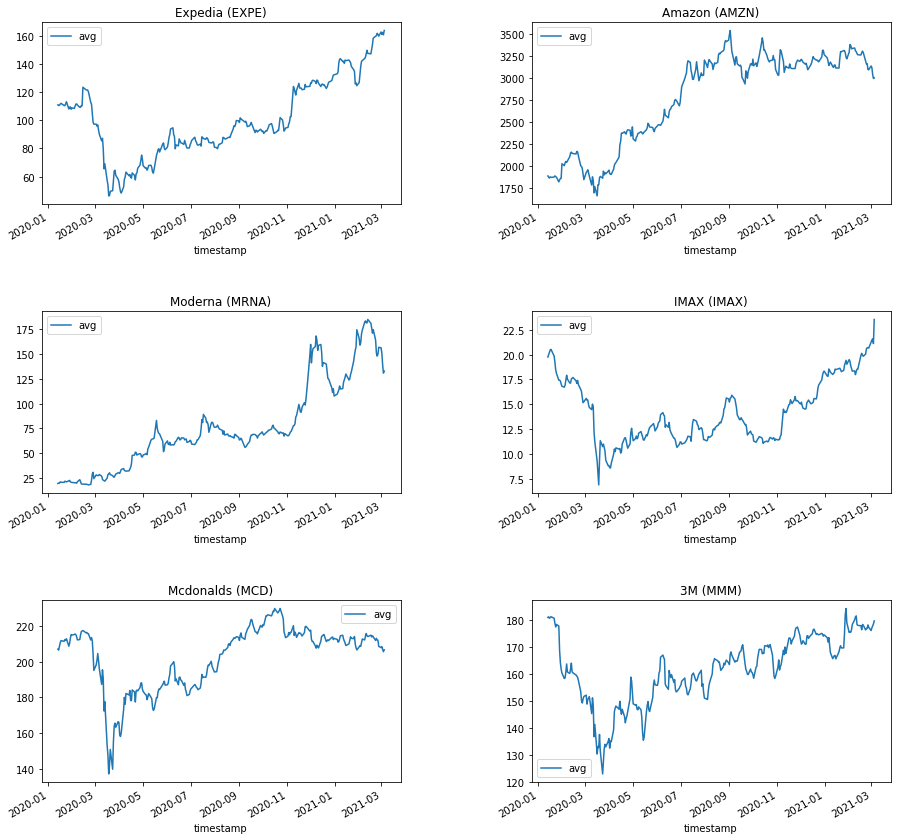

In [15]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(15,15))
fig.tight_layout(pad=10.0)

expe_final = expe_final.set_index("timestamp")
expe_final.plot(ax=ax[0,0])
ax[0,0].title.set_text("Expedia (EXPE)")

amzn_final = amzn_final.set_index("timestamp")
amzn_final.plot(ax=ax[0,1])
ax[0,1].title.set_text("Amazon (AMZN)")

mrna_final = mrna_final.set_index("timestamp")
mrna_final.plot(ax=ax[1,0])
ax[1,0].title.set_text("Moderna (MRNA)")

imax_final = imax_final.set_index("timestamp")
imax_final.plot(ax=ax[1,1])
ax[1,1].title.set_text("IMAX (IMAX)")

mcd_final = mcd_final.set_index("timestamp")
mcd_final.plot(ax=ax[2,0])
ax[2,0].title.set_text("Mcdonalds (MCD)")

mmm_final = mmm_final.set_index("timestamp")
mmm_final.plot(ax=ax[2,1])
ax[2,1].title.set_text("3M (MMM)")

### Joint Statistical Summary for Stocks

Here we took a glance at a **statistical summary** across all the stocks we are considering:

In [16]:
#renaming every price column to differentiate between stocks in joint summary
expe_final = expe_final.rename(columns={"avg":"expe"})
amzn_final = amzn_final.rename(columns={"avg":"amzn"})
mrna_final = mrna_final.rename(columns={"avg":"mrna"})
imax_final = imax_final.rename(columns={"avg":"imax"})
mcd_final = mcd_final.rename(columns={"avg":"mcd"})
mmm_final = mmm_final.rename(columns={"avg":"mmm"})

In [17]:
#merging stock dataframes into one dataframe
stocks = pd.merge(expe_final, amzn_final, left_index=True, right_index=True)
stocks = pd.merge(stocks, mrna_final, left_index=True, right_index=True)
stocks = pd.merge(stocks, imax_final, left_index=True, right_index=True)
stocks = pd.merge(stocks, mcd_final, left_index=True, right_index=True)
stocks = pd.merge(stocks, mmm_final, left_index=True, right_index=True)

In [18]:
stocks.describe()

,expe,amzn,mrna,imax,mcd,mmm
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,100.316298,2779.394766,76.450533,14.250986,202.334810,161.590709
std,27.313395,530.720093,43.956956,3.197836,17.866322,12.421891
min,46.335000,1665.330000,18.350000,6.865000,137.400000,123.015000
25%,83.020000,2367.360000,48.700000,11.580000,188.175000,154.255000
50%,95.495000,3081.412500,67.915000,13.360000,209.865000,162.565000
75%,122.805000,3196.095000,95.190000,16.930000,214.700000,170.935000
max,163.690000,3539.225000,184.315000,23.545000,229.570000,184.210000


### Time Series Chart for COVID-19 Data

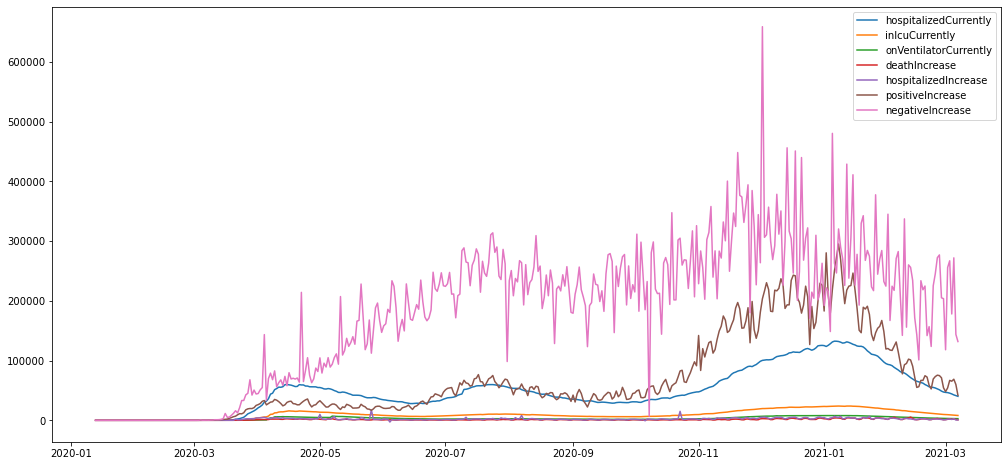

In [19]:
plt.figure(figsize=(17,8))
plt.plot("timestamp","hospitalizedCurrently", data=covid_final)
plt.plot("timestamp","inIcuCurrently", data=covid_final)
plt.plot("timestamp","onVentilatorCurrently", data=covid_final)
plt.plot("timestamp","deathIncrease", data=covid_final)
plt.plot("timestamp","hospitalizedIncrease", data=covid_final)
plt.plot("timestamp","positiveIncrease", data=covid_final)
plt.plot("timestamp","negativeIncrease", data=covid_final)
plt.legend()
plt.show()

### Correlation between Stocks and COVID-19 Data

Here we analysed the **correlation between stock prices and different COVID-19 statistics**:

In [20]:
#joining COVID-19 data to every individual stock dataframe
def join_with_covid(stock_df, covid_df):
    joint_df = pd.merge(stock_df, covid_df, how="outer", indicator=False, left_index=True, right_index=True)
    joint_df = joint_df[joint_df.iloc[:,0].notna()]
    joint_df = joint_df.replace(np.nan,0)
    return joint_df

In [21]:
covid_final

,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,deathIncrease,hospitalizedIncrease,positiveIncrease,negativeIncrease,timestamp
0,40199.0,8134.0,2802.0,842,726,41835,131835,2021-03-07
1,41401.0,8409.0,2811.0,1680,503,60015,143835,2021-03-06
2,42541.0,8634.0,2889.0,2221,2781,68787,271917,2021-03-05
3,44172.0,8970.0,2973.0,1743,1530,65487,177957,2021-03-04
4,45462.0,9359.0,3094.0,2449,2172,66836,267001,2021-03-03
5,46388.0,9465.0,3169.0,1728,1871,54248,255779,2021-03-02
6,46738.0,9595.0,3171.0,1241,1024,48092,118077,2021-03-01
7,47352.0,9802.0,3245.0,1051,879,54349,203599,2021-02-28
8,48871.0,10114.0,3335.0,1847,1428,71245,205090,2021-02-27
9,51112.0,10466.0,3466.0,2141,1868,74857,276829,2021-02-26


In [22]:
covid_final = covid_final.set_index("timestamp")
expe_covid = join_with_covid(expe_final, covid_final)
amzn_covid = join_with_covid(amzn_final, covid_final)
mrna_covid = join_with_covid(mrna_final, covid_final)
imax_covid = join_with_covid(imax_final, covid_final)
mcd_covid = join_with_covid(mcd_final, covid_final)
mmm_covid = join_with_covid(mmm_final, covid_final)

Text(0.5, 1.0, '3M Correlations with Covid19')

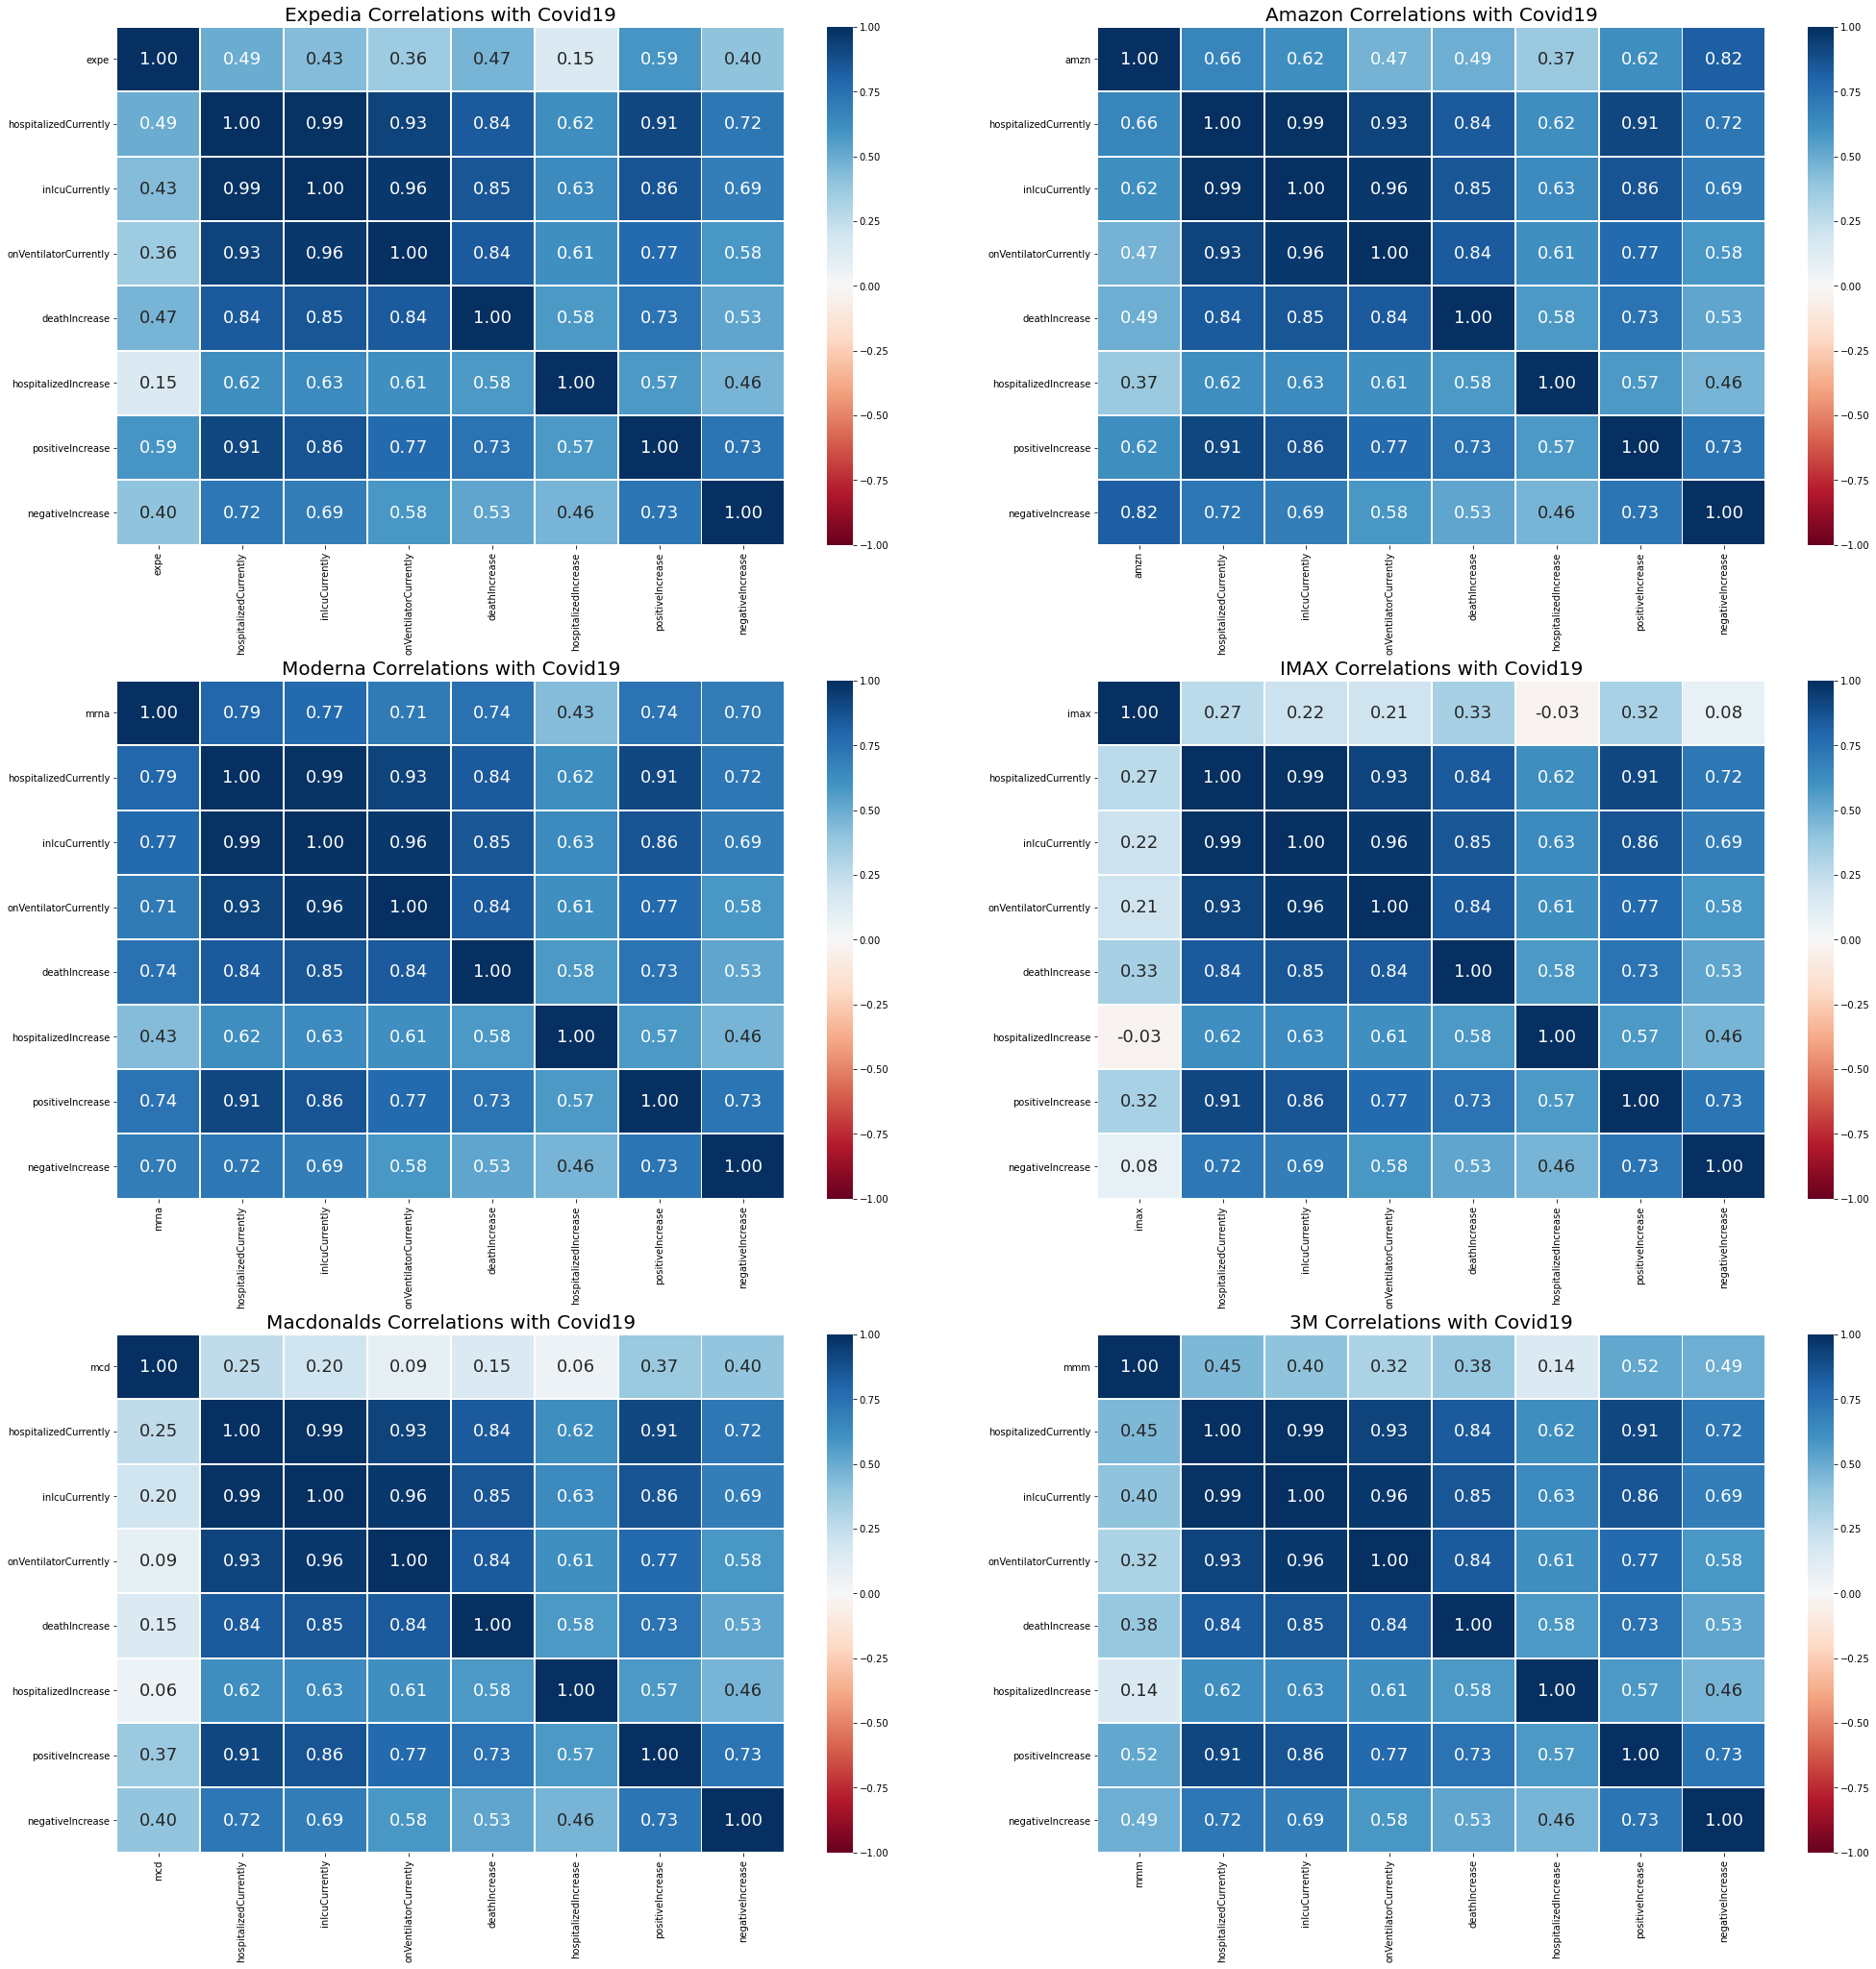

In [24]:
#plotting correlation heatmap for every stock's price against every COVID-19 variable
f, axes = plt.subplots(3, 2, figsize=(30, 30))
f.tight_layout(pad=12.0)
expehmap = sb.heatmap(expe_covid.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu", ax=axes[0,0])
amznhmap = sb.heatmap(amzn_covid.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu", ax=axes[0,1])
mrnahmap = sb.heatmap(mrna_covid.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu", ax=axes[1,0])
imaxhmap = sb.heatmap(imax_covid.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu", ax=axes[1,1])
mcdhmap = sb.heatmap(mcd_covid.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu", ax=axes[2,0])
mmmhmap = sb.heatmap(mmm_covid.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu", ax=axes[2,1])

expehmap.set_title('Expedia Correlations with Covid19', fontsize = 20)
amznhmap.set_title('Amazon Correlations with Covid19', fontsize = 20)
mrnahmap.set_title('Moderna Correlations with Covid19', fontsize = 20)
imaxhmap.set_title('IMAX Correlations with Covid19', fontsize = 20)
mcdhmap.set_title('Macdonalds Correlations with Covid19', fontsize = 20)
mmmhmap.set_title('3M Correlations with Covid19', fontsize = 20)

## Step 4a: Predicting Stock Price Movement with Decision Trees

Based on the different COVID-19 variables, we want to **classify any particular stock at any particular price on any particular day as either "buy" or "don't buy"** based on our **prediction of the next day's stock price**.

This is the function we used to **label a stock as "buy" or "don't buy"**:

In [25]:
def classify(df):
    df = df.reset_index()
    
    #since COVID-19 data lags by one day (i.e. Monday COVID-19 numbers only broadcasted on Tuesday)
    df["new_timestamp"] = df["timestamp"].shift(-1)
    df["avg"] = df.iloc[:,1].shift(-1)
    
    #taking relevant columns
    df = df.iloc[:,2:]
    
    #computing change in stock price using tomorrow's price - today's price
    df["change"] = df["avg"].shift(-1) - df["avg"]
    
    #labelling data as "1" if stock price increases tomorrow (meaning "buy"), otherwise "0" (meaning "don't buy")
    df["buy"] = df["change"].apply(lambda x: 1 if x>0 else 0)
    
    #taking relevant rows
    df = df.iloc[32:-2,:]
    
    df = df.reset_index(drop=True)
    return df

In order to do our stock price predictions and thus "buy"/"don't buy" classifications, we used this function to train **Decision Tree Models** based on pre-labelled stock price data:

In [26]:
from sklearn.tree import plot_tree

def dtree_predict (df, depth):
    #extract Response and Predictors
    y = pd.DataFrame(df.buy)
    X = pd.DataFrame(df.iloc[:,0:7]) 

    #split the Dataset into Train and Test
    X_train = X.iloc[:193,]
    X_test = X.iloc[193:,]
    y_train = y.iloc[:193,]
    y_test = y.iloc[193:,]

    #decision Tree using Train Data
    dectree = DecisionTreeClassifier(max_depth = depth)  # create the decision tree object
    dectree.fit(X_train, y_train)                    # train the decision tree model

    #predict Response corresponding to Predictors
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)

    #check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, y_train))
    print()

    #check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print()

    #plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].title.set_text("Train Accuracy")
    axes[1].title.set_text("Test Accuracy")
    sb.heatmap(sk_confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(sk_confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
    
    return dectree, X_test.columns



def dtree_print(tree,xtest):
    f = plt.figure(figsize=(20,20))
    plot_tree(tree, filled=True, rounded=True,
            feature_names=xtest,
              class_names=["Not Buy","Buy"])


### Decision Tree for Travel - Expedia (ticker: EXPE)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8134715025906736

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5483870967741935



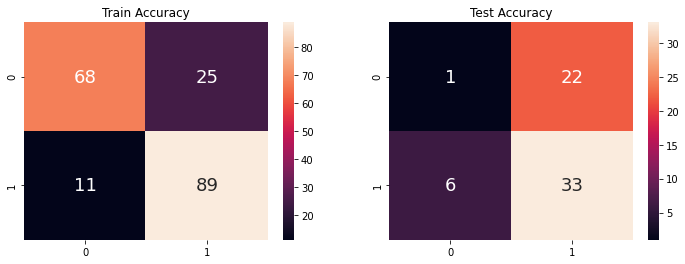

In [27]:
expe_dtree = expe_covid.copy()
expe_dtree = classify(expe_dtree)

expetree,expeheader = dtree_predict(expe_dtree,5)

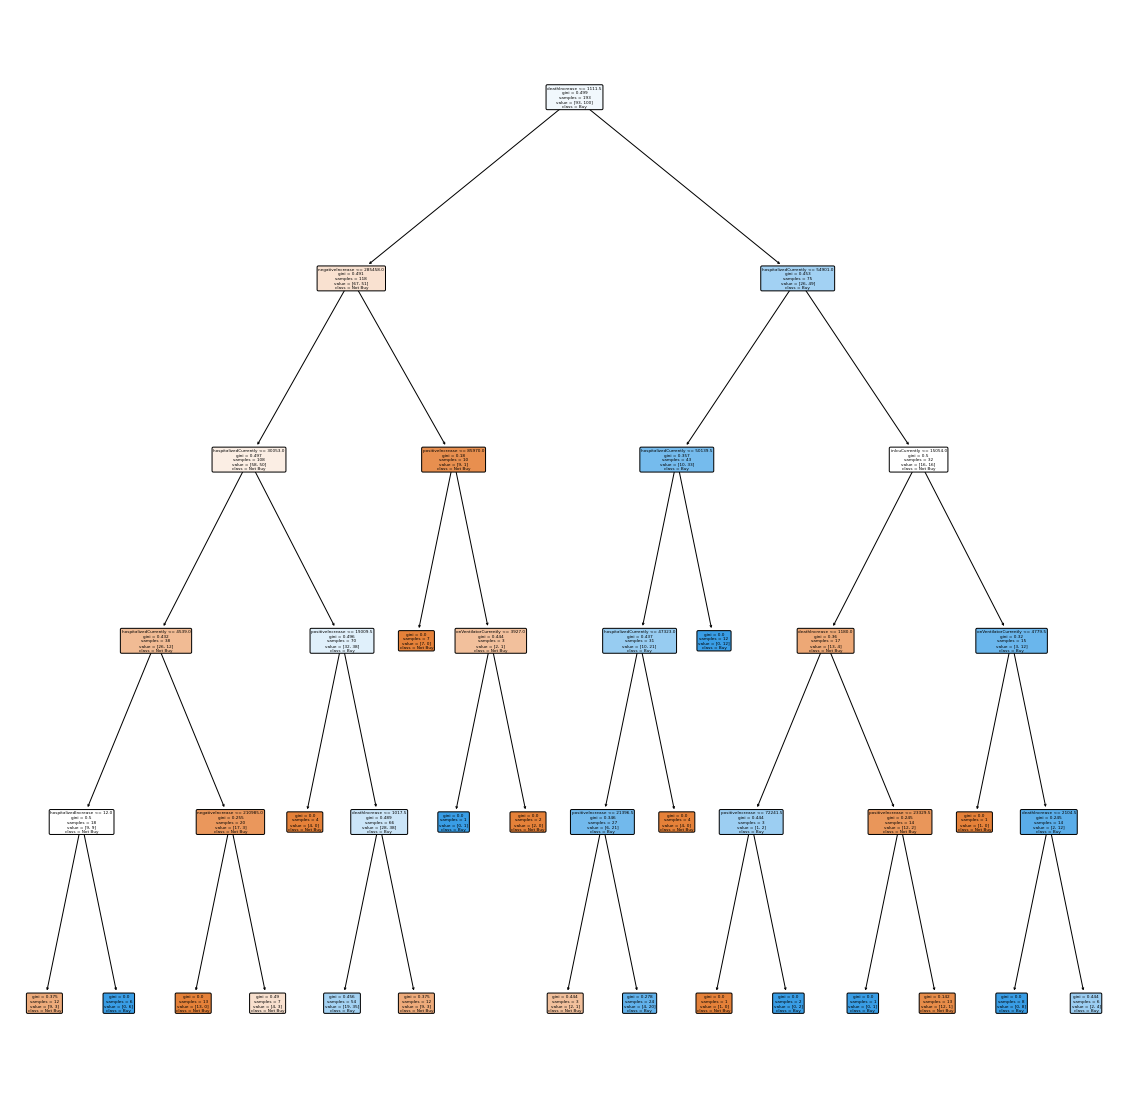

In [29]:
dtree_print(expetree,expeheader)

### Decision Tree for E-commerce - Amazon (ticker: AMZN)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7927461139896373

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.532258064516129



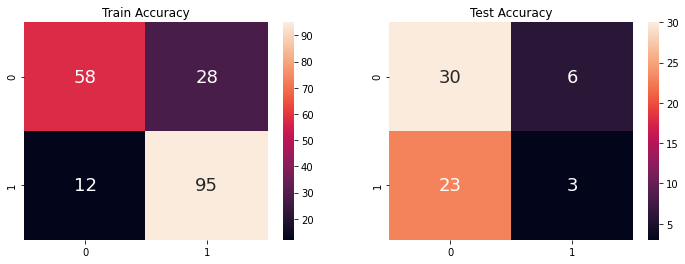

In [30]:
amzn_dtree = amzn_covid.copy()
amzn_dtree = classify(amzn_dtree)

amzntree,amznheader = dtree_predict(amzn_dtree,7)

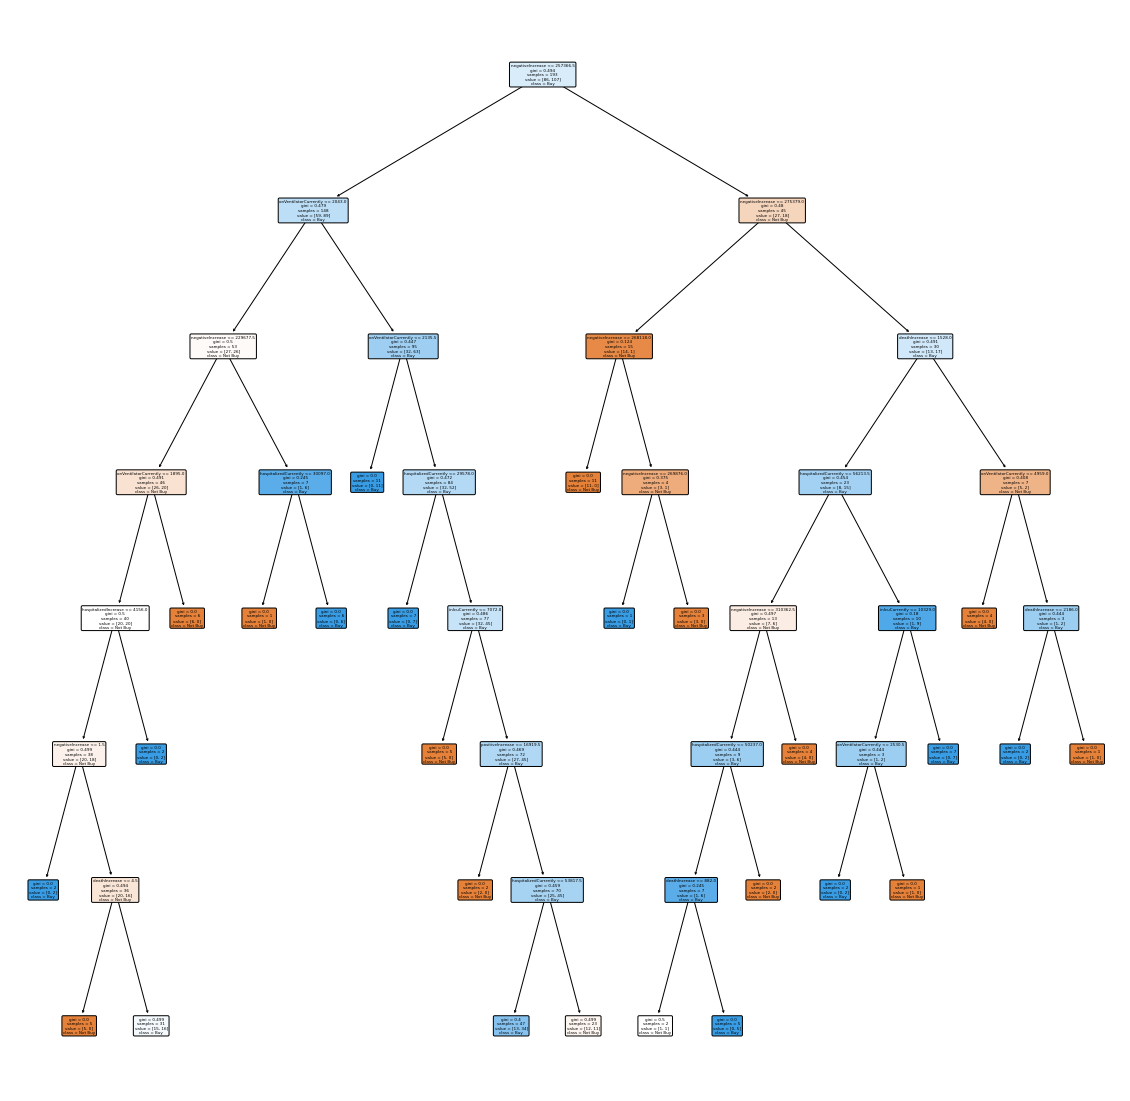

In [31]:
dtree_print(amzntree,amznheader)

### Decision Tree for Bio-medical - Moderna (ticker: MRNA)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7823834196891192

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6129032258064516



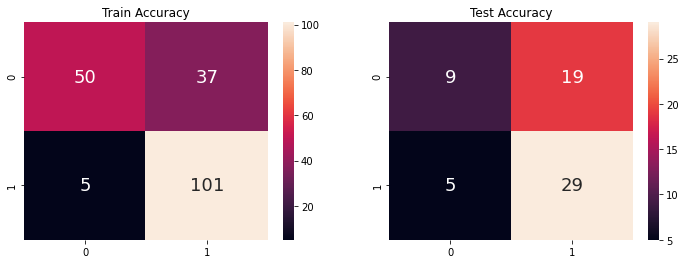

In [32]:
mrna_dtree = mrna_covid.copy()
mrna_dtree = classify(mrna_dtree)

mrnatree, mrnaheader = dtree_predict(mrna_dtree,5)

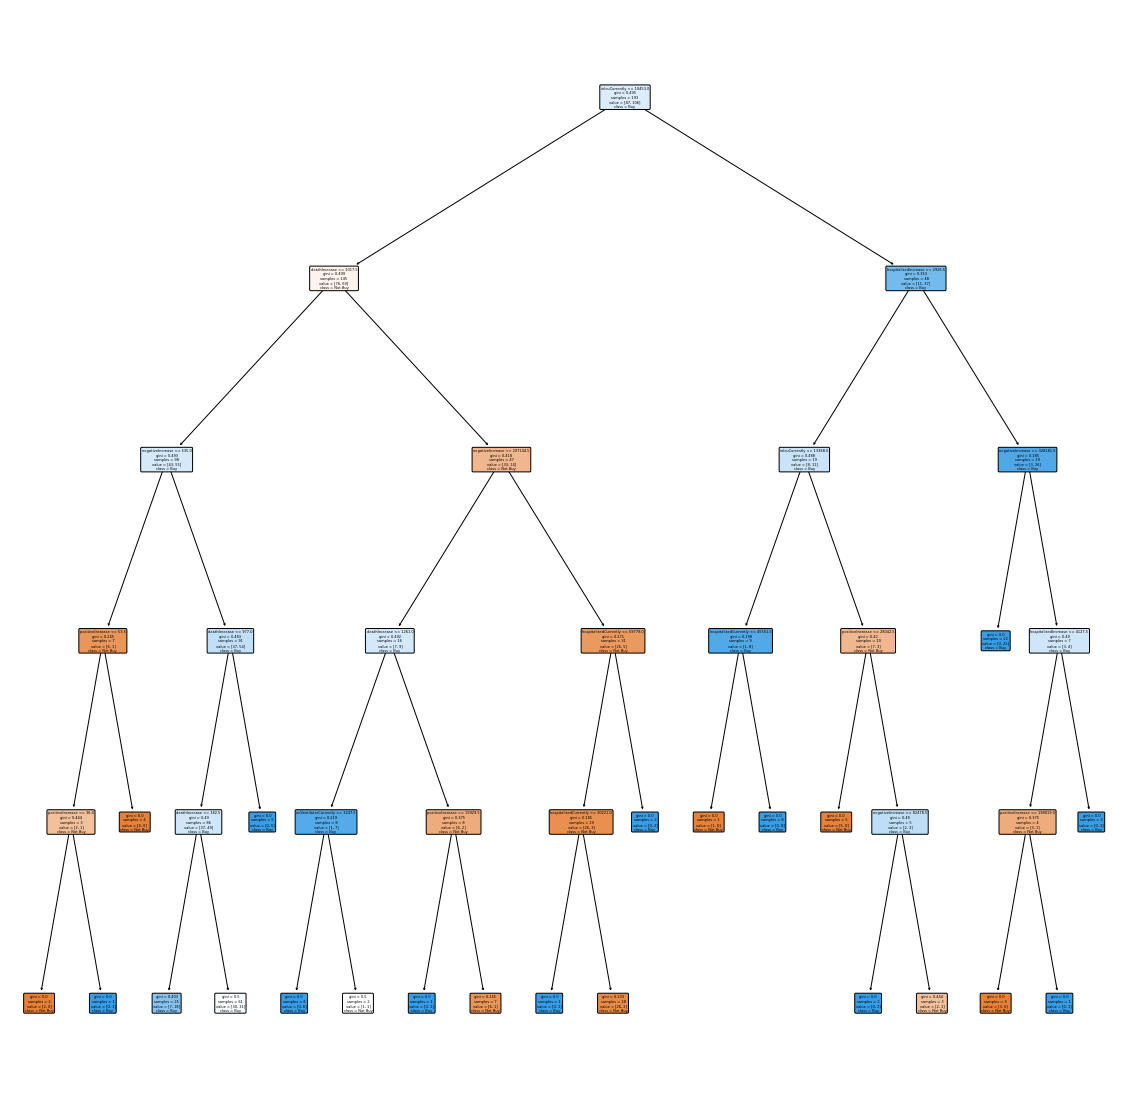

In [33]:
dtree_print(mrnatree,mrnaheader)

### Decision Tree for Entertainment - IMAX (ticker: IMAX)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7202072538860104

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7419354838709677



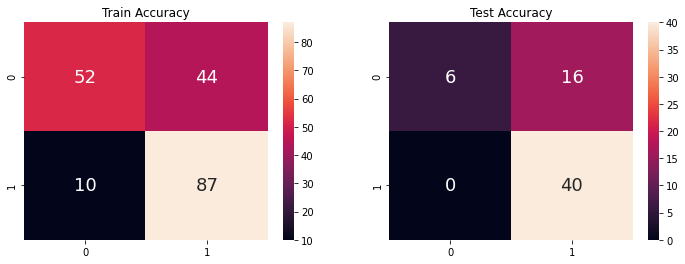

In [34]:
imax_dtree = imax_covid.copy()
imax_dtree = classify(imax_dtree)

imaxtree,imaxheader = dtree_predict(imax_dtree,3)

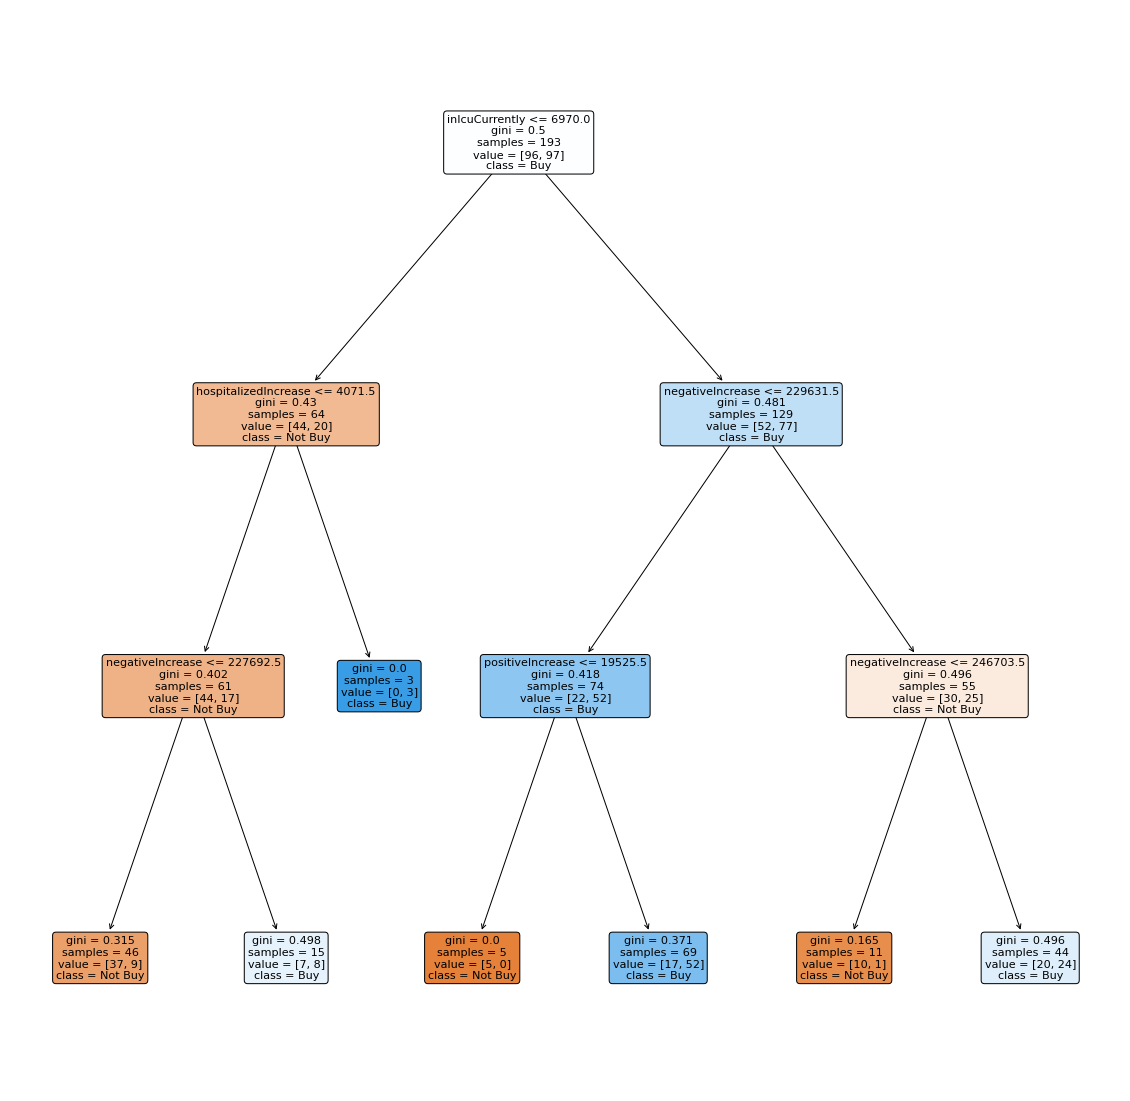

In [35]:
dtree_print(imaxtree,imaxheader)

### Decision Tree for Food and Beverage - McDonald's (ticker: MCD)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7046632124352331

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5



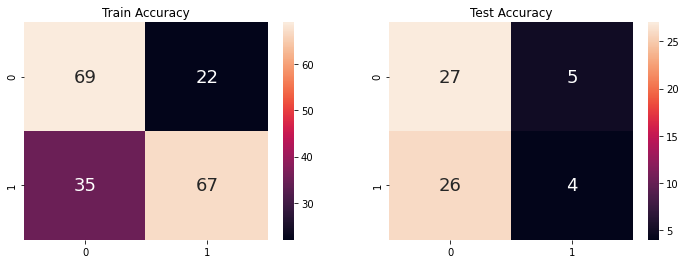

In [36]:
mcd_dtree = mcd_covid.copy()
mcd_dtree = classify(mcd_dtree)

mcdtree, mcdheader = dtree_predict(mcd_dtree,5)

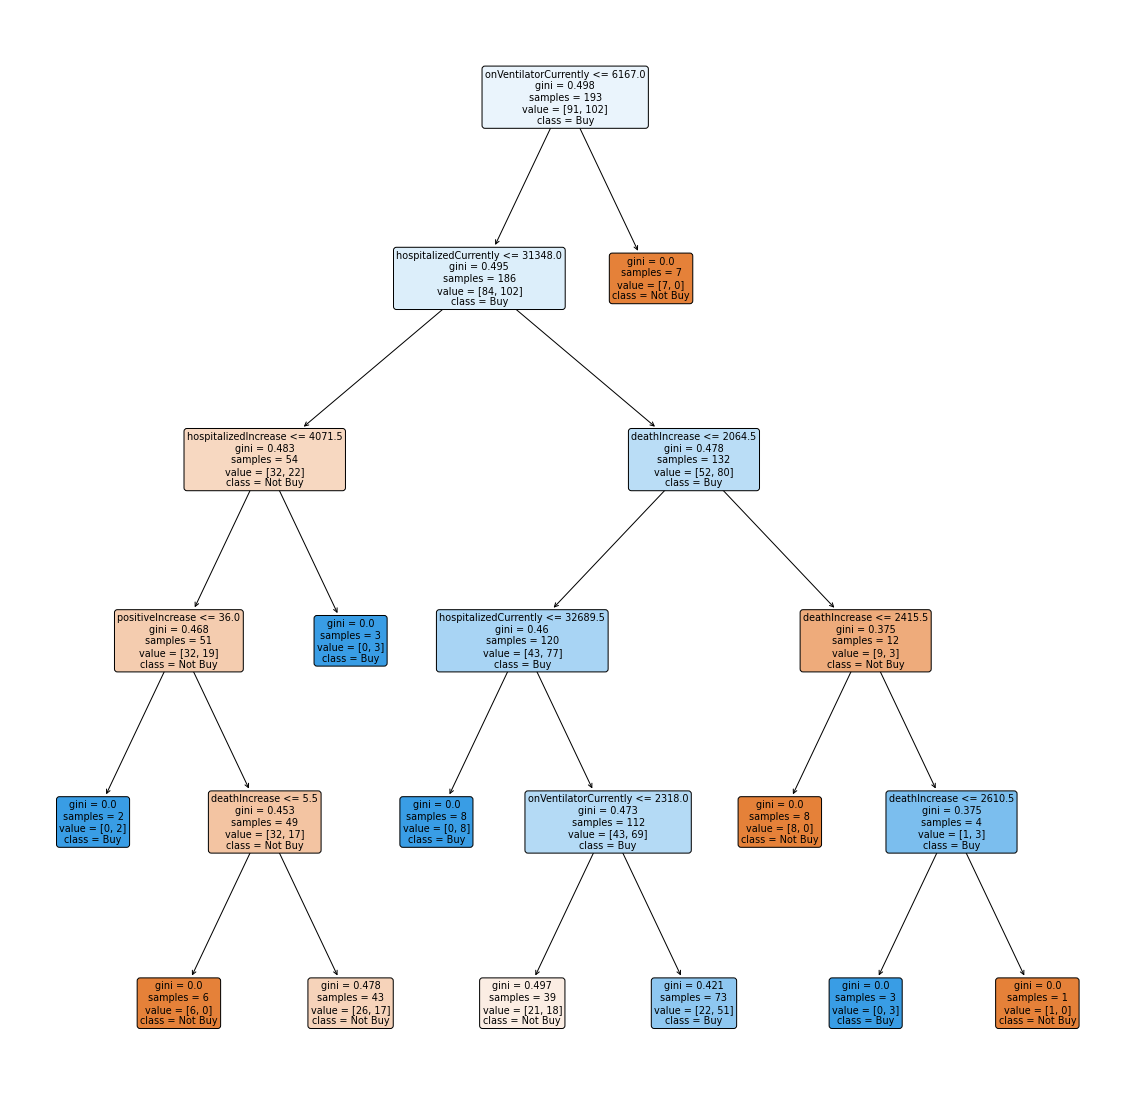

In [37]:
dtree_print(mcdtree,mcdheader)

### Decision Tree for Pandemic Hygience and Protection - 3M (ticker: MMM)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5854922279792746

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.532258064516129



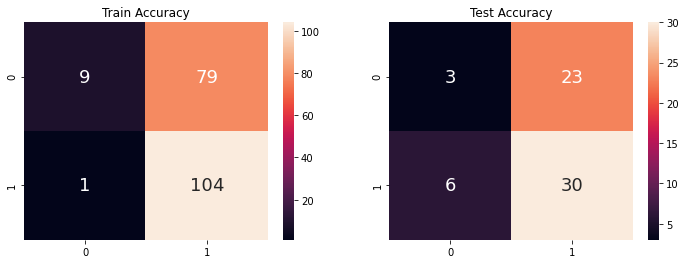

In [38]:
mmm_dtree = mmm_covid.copy()
mmm_dtree = classify(mmm_dtree)

mmmtree,mmmheader = dtree_predict(mmm_dtree,2)

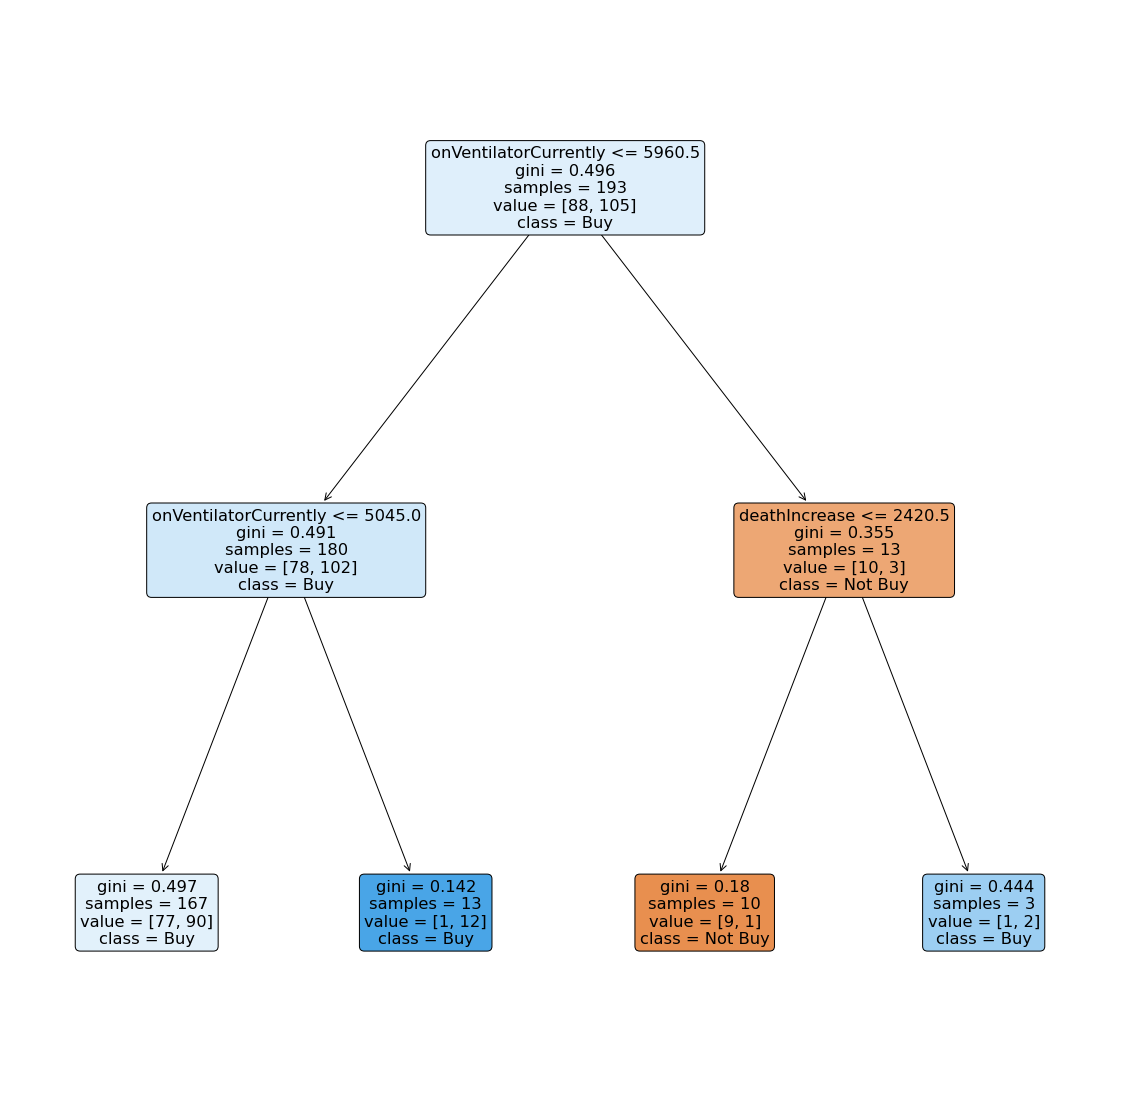

In [39]:
dtree_print(mmmtree,mmmheader)

## Step 4b: Predicting Stock Price Movement with Logistic Regression

Another model (not part of the CZ1115 curriculum) that we learned about and trained was the **Logistic Regression Model**, which also aims to **classify a particular stock price, along with COVID-19 data for that day, as "buy" or "don't buy"**:

In [40]:
def time_split_predict(df, n):
    #splitting dataset into training and testing data based on time
    x = df.iloc[:,0:n]
    y = df.buy
    x_train = x.iloc[:193,]
    x_test = x.iloc[193:,]
    y_train = y.iloc[:193,]
    y_test = y.iloc[193:,]
    
    #training Logistic Regression Model
    model = sm.Logit(y_train,x_train)
    result = model.fit()
    
    #getting predictions from Logistic Regression Model
    train_pred = result.predict(x_train)
    test_pred = result.predict(x_test)
    return y_train, y_test, result, train_pred, test_pred

def transform(data):
    x = [1 if x>0.5 else 0 for x in data]
    return x

def accuracy(arr):
    #computes accuracy of predictions
    return (arr[0][0] + arr[1][1])/(arr[0][0]+arr[0][1]+arr[1][0]+arr[1][1])

### Logistic Regression for Travel - Expedia (ticker: EXPE)

In [41]:
# first modelling considering all COVID-19 variables
expe_log = expe_covid.copy()
expe_log = classify(expe_log)
expe_y_train, expe_y_test, expe_result, expe_train_pred, expe_test_pred = time_split_predict(expe_log, 7)

expe_result.summary()

Optimization terminated successfully.
         Current function value: 0.666978
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    buy   No. Observations:                  193
Model:                          Logit   Df Residuals:                      186
Method:                           MLE   Df Model:                            6
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                 0.03684
Time:                        12:32:58   Log-Likelihood:                -128.73
converged:                       True   LL-Null:                       -133.65
Covariance Type:            nonrobust   LLR p-value:                    0.1312
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
hospitalizedCurrently -5.218e-05   4.75e-05     -1.098      0.272      -0.000     4.1e-05
inIcuCurrently         5.684e-05      0.000      0.218      0.828      -0.000       0.001
onVentilatorCurrently     0.0001      0.000      0.497      0.620      -0.000       0.001
deathIncrease             0.0009      0.000      1.919      0.055   -1.88e-05       0.002
hospitalizedIncrease     -0.0001      0.000     -1.305      0.192      -0.000    6.78e-05
positiveIncrease       1.327e-05   7.09e-06      1.873      0.061   -6.18e-07    2.72e-05
negativeIncrease       6.839e-07   2.14e-06      0.320      0.749    -3.5e-06    4.87e-06
=========================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.669422
         Iterations 5
Accuracy of Model Predictions 	Train Dataset
Classification Accuracy 	: 0.5803108808290155

Accuracy of Model Predictions 	Test Dataset
Classification Accuracy 	: 0.5645161290322581



<AxesSubplot:title={'center':'Test Accuracy'}>

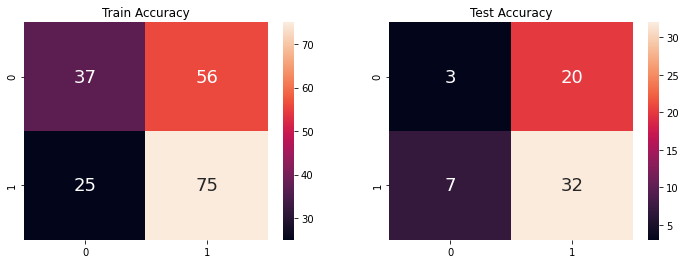

In [42]:
# removing COVID-19 variables with high P-value
expe_log_refined = expe_log.copy()
expe_log_refined = expe_log_refined[["hospitalizedCurrently","deathIncrease", "hospitalizedIncrease","positiveIncrease","buy"]]
r_expe_y_train, r_expe_y_test, r_expe_result, r_expe_train_pred, r_expe_test_pred = time_split_predict(expe_log_refined, 4)

r_expe_result.summary()

r_expe_y_train_tf = transform(r_expe_y_train)
r_expe_train_pred_tf = transform(r_expe_train_pred)
r_expe_y_test_tf = transform(r_expe_y_test)
r_expe_test_pred_tf = transform(r_expe_test_pred)

#check accuracy (on Train Data)
print("Accuracy of Model Predictions \tTrain Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_expe_y_train_tf, r_expe_train_pred_tf)))
print()

#check accuracy (on Test Data)
print("Accuracy of Model Predictions \tTest Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_expe_y_test_tf, r_expe_test_pred_tf)))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].title.set_text("Train Accuracy")
axes[1].title.set_text("Test Accuracy")
sb.heatmap(sk_confusion_matrix(r_expe_y_train_tf, r_expe_train_pred_tf),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(sk_confusion_matrix(r_expe_y_test_tf, r_expe_test_pred_tf), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

### Logistic Regression for E-commerce - Amazon (ticker: AMZN)

In [43]:
# first modelling considering all COVID-19 variables
amzn_log = amzn_covid.copy()
amzn_log = classify(amzn_log)
amzn_y_train, amzn_y_test, amzn_result, amzn_train_pred, amzn_test_pred = time_split_predict(amzn_log,7)

amzn_result.summary()

Optimization terminated successfully.
         Current function value: 0.678648
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    buy   No. Observations:                  193
Model:                          Logit   Df Residuals:                      186
Method:                           MLE   Df Model:                            6
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                 0.01247
Time:                        12:32:59   Log-Likelihood:                -130.98
converged:                       True   LL-Null:                       -132.63
Covariance Type:            nonrobust   LLR p-value:                    0.7694
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
hospitalizedCurrently  4.982e-06   4.63e-05      0.108      0.914   -8.58e-05    9.57e-05
inIcuCurrently         5.729e-05      0.000      0.222      0.824      -0.000       0.001
onVentilatorCurrently  7.536e-05      0.000      0.281      0.779      -0.000       0.001
deathIncrease            -0.0003      0.000     -0.644      0.519      -0.001       0.001
hospitalizedIncrease  -5.728e-05    8.3e-05     -0.690      0.490      -0.000       0.000
positiveIncrease      -7.092e-06   6.62e-06     -1.071      0.284   -2.01e-05    5.88e-06
negativeIncrease       3.399e-07   2.12e-06      0.160      0.873   -3.81e-06    4.49e-06
=========================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.684850
         Iterations 3
Accuracy of Model Predictions 	Train Dataset
Classification Accuracy 	: 0.5544041450777202

Accuracy of Model Predictions 	Test Dataset
Classification Accuracy 	: 0.532258064516129



<AxesSubplot:title={'center':'Test Accuracy'}>

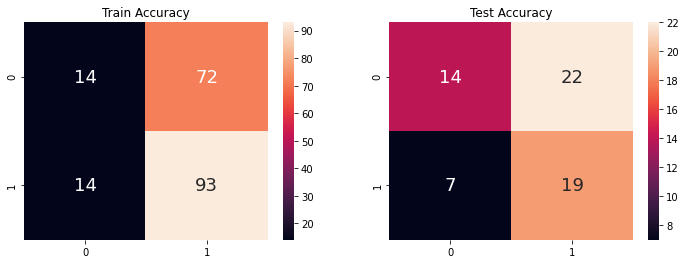

In [44]:
# removing COVID-19 variables with high P-value
amzn_log_refined = amzn_log.copy()
amzn_log_refined = amzn_log_refined[["positiveIncrease","hospitalizedIncrease","deathIncrease","negativeIncrease","buy"]]
r_amzn_y_train, r_amzn_y_test, r_amzn_result, r_amzn_train_pred, r_amzn_test_pred = time_split_predict(amzn_log_refined, 4)

r_amzn_result.summary()

r_amzn_y_train_tf = transform(r_amzn_y_train)
r_amzn_train_pred_tf = transform(r_amzn_train_pred)
r_amzn_y_test_tf = transform(r_amzn_y_test)
r_amzn_test_pred_tf = transform(r_amzn_test_pred)

#check accuracy (on Train Data)
print("Accuracy of Model Predictions \tTrain Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_amzn_y_train_tf, r_amzn_train_pred_tf)))
print()

#check accuracy (on Test Data)
print("Accuracy of Model Predictions \tTest Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_amzn_y_test_tf, r_amzn_test_pred_tf)))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].title.set_text("Train Accuracy")
axes[1].title.set_text("Test Accuracy")
sb.heatmap(sk_confusion_matrix(r_amzn_y_train_tf, r_amzn_train_pred_tf),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(sk_confusion_matrix(r_amzn_y_test_tf, r_amzn_test_pred_tf), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

### Logistic Regression for Bio-medical - Moderna (ticker: MRNA)

In [45]:
mrna_log = mrna_covid.copy()
mrna_log = classify(mrna_log)
mrna_y_train, mrna_y_test, mrna_result, mrna_train_pred, mrna_test_pred = time_split_predict(mrna_log,7)

mrna_result.summary()

Optimization terminated successfully.
         Current function value: 0.658810
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    buy   No. Observations:                  193
Model:                          Logit   Df Residuals:                      186
Method:                           MLE   Df Model:                            6
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                 0.04284
Time:                        12:32:59   Log-Likelihood:                -127.15
converged:                       True   LL-Null:                       -132.84
Covariance Type:            nonrobust   LLR p-value:                   0.07730
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
hospitalizedCurrently -3.201e-05   4.74e-05     -0.676      0.499      -0.000    6.08e-05
inIcuCurrently         8.333e-05      0.000      0.314      0.753      -0.000       0.001
onVentilatorCurrently     0.0001      0.000      0.541      0.588      -0.000       0.001
deathIncrease           8.65e-05      0.000      0.189      0.850      -0.001       0.001
hospitalizedIncrease   7.182e-05    9.3e-05      0.772      0.440      -0.000       0.000
positiveIncrease       1.589e-05   7.56e-06      2.103      0.036    1.08e-06    3.07e-05
negativeIncrease      -3.506e-06   2.19e-06     -1.599      0.110    -7.8e-06    7.92e-07
=========================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.665296
         Iterations 4
Accuracy of Model Predictions 	Train Dataset
Classification Accuracy 	: 0.5077720207253886

Accuracy of Model Predictions 	Test Dataset
Classification Accuracy 	: 0.5645161290322581



<AxesSubplot:title={'center':'Test Accuracy'}>

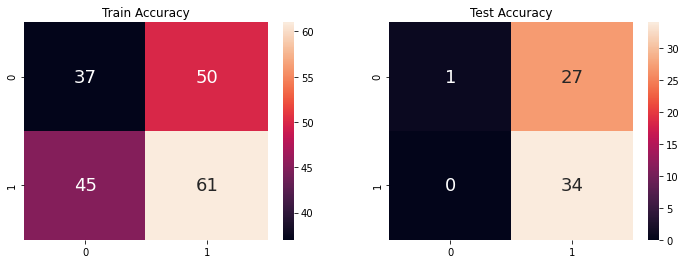

In [46]:
# removing COVID-19 variables with high P-value
mrna_log_refined = mrna_log.copy()
mrna_log_refined = mrna_log_refined[["positiveIncrease","negativeIncrease","hospitalizedIncrease","buy"]]
r_mrna_y_train, r_mrna_y_test, r_mrna_result, r_mrna_train_pred, r_mrna_test_pred = time_split_predict(mrna_log_refined, 3)

r_mrna_result.summary()

r_mrna_y_train_tf = transform(r_mrna_y_train)
r_mrna_train_pred_tf = transform(r_mrna_train_pred)
r_mrna_y_test_tf = transform(r_mrna_y_test)
r_mrna_test_pred_tf = transform(r_mrna_test_pred)

#check accuracy (on Train Data)
print("Accuracy of Model Predictions \tTrain Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_mrna_y_train_tf, r_mrna_train_pred_tf)))
print()

#check accuracy (on Test Data)
print("Accuracy of Model Predictions \tTest Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_mrna_y_test_tf, r_mrna_test_pred_tf)))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].title.set_text("Train Accuracy")
axes[1].title.set_text("Test Accuracy")
sb.heatmap(sk_confusion_matrix(r_mrna_y_train_tf, r_mrna_train_pred_tf),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(sk_confusion_matrix(r_mrna_y_test_tf, r_mrna_test_pred_tf), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

### Logistic Regression for Entertainment - IMAX (ticker: IMAX)

In [47]:
imax_log = imax_covid.copy()
imax_log = classify(imax_log)
imax_y_train, imax_y_test, imax_result, imax_train_pred, imax_test_pred = time_split_predict(imax_log,7)

imax_result.summary()

Optimization terminated successfully.
         Current function value: 0.681670
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    buy   No. Observations:                  193
Model:                          Logit   Df Residuals:                      186
Method:                           MLE   Df Model:                            6
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                 0.01654
Time:                        12:33:00   Log-Likelihood:                -131.56
converged:                       True   LL-Null:                       -133.77
Covariance Type:            nonrobust   LLR p-value:                    0.6194
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
hospitalizedCurrently  -7.43e-05   4.67e-05     -1.590      0.112      -0.000    1.73e-05
inIcuCurrently            0.0005      0.000      1.797      0.072   -4.24e-05       0.001
onVentilatorCurrently    -0.0003      0.000     -1.266      0.206      -0.001       0.000
deathIncrease            -0.0001      0.000     -0.258      0.796      -0.001       0.001
hospitalizedIncrease   1.521e-05   8.23e-05      0.185      0.853      -0.000       0.000
positiveIncrease       3.961e-06   6.63e-06      0.598      0.550   -9.03e-06     1.7e-05
negativeIncrease      -3.856e-07   2.11e-06     -0.182      0.855   -4.53e-06    3.76e-06
=========================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.682952
         Iterations 4
Accuracy of Model Predictions 	Train Dataset
Classification Accuracy 	: 0.5595854922279793

Accuracy of Model Predictions 	Test Dataset
Classification Accuracy 	: 0.5161290322580645



<AxesSubplot:title={'center':'Test Accuracy'}>

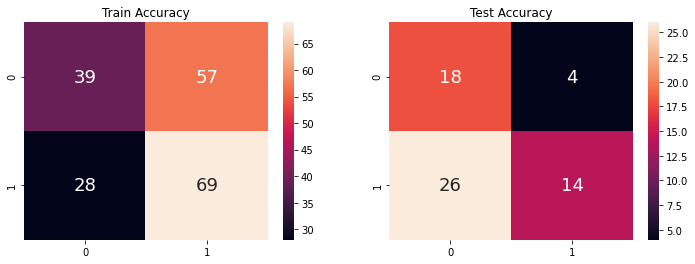

In [48]:
# removing COVID-19 variables with high P-value
imax_log_refined = imax_log.copy()
imax_log_refined = imax_log_refined[["hospitalizedCurrently","inIcuCurrently","onVentilatorCurrently","buy"]]
r_imax_y_train, r_imax_y_test, r_imax_result, r_imax_train_pred, r_imax_test_pred = time_split_predict(imax_log_refined, 3)

r_imax_result.summary()

r_imax_y_train_tf = transform(r_imax_y_train)
r_imax_train_pred_tf = transform(r_imax_train_pred)
r_imax_y_test_tf = transform(r_imax_y_test)
r_imax_test_pred_tf = transform(r_imax_test_pred)

#check accuracy (on Train Data)
print("Accuracy of Model Predictions \tTrain Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_imax_y_train_tf, r_imax_train_pred_tf)))
print()

#check accuracy (on Test Data)
print("Accuracy of Model Predictions \tTest Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_imax_y_test_tf, r_imax_test_pred_tf)))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].title.set_text("Train Accuracy")
axes[1].title.set_text("Test Accuracy")
sb.heatmap(sk_confusion_matrix(r_imax_y_train_tf, r_imax_train_pred_tf),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(sk_confusion_matrix(r_imax_y_test_tf, r_imax_test_pred_tf), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

### Logistic Regression for Food and Beverage - McDonald's (ticker: MCD)

In [49]:
mcd_log = mcd_covid.copy()
mcd_log = classify(mcd_log)
mcd_y_train, mcd_y_test, mcd_result, mcd_train_pred, mcd_test_pred = time_split_predict(mcd_log,7)

mcd_result.summary()

Optimization terminated successfully.
         Current function value: 0.684393
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    buy   No. Observations:                  193
Model:                          Logit   Df Residuals:                      186
Method:                           MLE   Df Model:                            6
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                 0.01031
Time:                        12:33:00   Log-Likelihood:                -132.09
converged:                       True   LL-Null:                       -133.46
Covariance Type:            nonrobust   LLR p-value:                    0.8393
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
hospitalizedCurrently  1.246e-05   4.63e-05      0.269      0.788   -7.83e-05       0.000
inIcuCurrently         6.157e-05      0.000      0.242      0.809      -0.000       0.001
onVentilatorCurrently    -0.0001      0.000     -0.404      0.686      -0.001       0.000
deathIncrease            -0.0004      0.000     -0.998      0.318      -0.001       0.000
hospitalizedIncrease   2.244e-06   8.14e-05      0.028      0.978      -0.000       0.000
positiveIncrease      -7.962e-06   6.66e-06     -1.195      0.232    -2.1e-05     5.1e-06
negativeIncrease       1.155e-06    2.1e-06      0.549      0.583   -2.97e-06    5.28e-06
=========================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.687546
         Iterations 3
Accuracy of Model Predictions 	Train Dataset
Classification Accuracy 	: 0.538860103626943

Accuracy of Model Predictions 	Test Dataset
Classification Accuracy 	: 0.5161290322580645



<AxesSubplot:title={'center':'Test Accuracy'}>

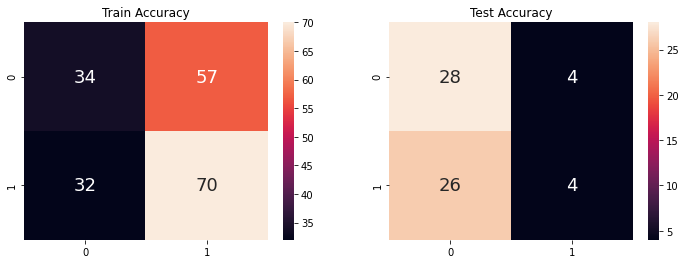

In [50]:
# removing COVID-19 variables with high P-value
mcd_log_refined = mcd_log.copy()
mcd_log_refined = mcd_log_refined[["positiveIncrease","deathIncrease","negativeIncrease","buy"]]
r_mcd_y_train, r_mcd_y_test, r_mcd_result, r_mcd_train_pred, r_mcd_test_pred = time_split_predict(mcd_log_refined, 3)

r_mcd_result.summary()

r_mcd_y_train_tf = transform(r_mcd_y_train)
r_mcd_train_pred_tf = transform(r_mcd_train_pred)
r_mcd_y_test_tf = transform(r_mcd_y_test)
r_mcd_test_pred_tf = transform(r_mcd_test_pred)

#check accuracy (on Train Data)
print("Accuracy of Model Predictions \tTrain Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_mcd_y_train_tf, r_mcd_train_pred_tf)))
print()

#check accuracy (on Test Data)
print("Accuracy of Model Predictions \tTest Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_mcd_y_test_tf, r_mcd_test_pred_tf)))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].title.set_text("Train Accuracy")
axes[1].title.set_text("Test Accuracy")
sb.heatmap(sk_confusion_matrix(r_mcd_y_train_tf, r_mcd_train_pred_tf),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(sk_confusion_matrix(r_mcd_y_test_tf, r_mcd_test_pred_tf), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

### Logistic Regression for Pandemic Hygience and Protection - 3M (ticker: MMM)

In [51]:
mmm_log = mmm_covid.copy()
mmm_log = classify(mmm_log)
mmm_y_train, mmm_y_test, mmm_result, mmm_train_pred, mmm_test_pred = time_split_predict(mmm_log,7)

mmm_result.summary()

Optimization terminated successfully.
         Current function value: 0.682188
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    buy   No. Observations:                  193
Model:                          Logit   Df Residuals:                      186
Method:                           MLE   Df Model:                            6
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                 0.01026
Time:                        12:33:01   Log-Likelihood:                -131.66
converged:                       True   LL-Null:                       -133.03
Covariance Type:            nonrobust   LLR p-value:                    0.8418
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
hospitalizedCurrently   4.19e-05   4.67e-05      0.898      0.369   -4.95e-05       0.000
inIcuCurrently           -0.0002      0.000     -0.838      0.402      -0.001       0.000
onVentilatorCurrently -5.225e-07      0.000     -0.002      0.998      -0.001       0.001
deathIncrease             0.0002      0.000      0.476      0.634      -0.001       0.001
hospitalizedIncrease   4.498e-05   8.39e-05      0.536      0.592      -0.000       0.000
positiveIncrease       7.482e-07   6.74e-06      0.111      0.912   -1.25e-05     1.4e-05
negativeIncrease       -3.01e-07   2.11e-06     -0.143      0.887   -4.43e-06    3.83e-06
=========================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.688584
         Iterations 4
Accuracy of Model Predictions 	Train Dataset
Classification Accuracy 	: 0.533678756476684

Accuracy of Model Predictions 	Test Dataset
Classification Accuracy 	: 0.5806451612903226



<AxesSubplot:title={'center':'Test Accuracy'}>

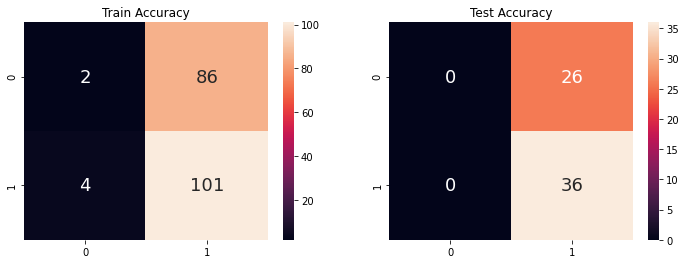

In [52]:
# removing COVID-19 variables with high P-value
mmm_log_refined = mmm_log.copy()
mmm_log_refined = mmm_log_refined[["inIcuCurrently","hospitalizedIncrease","buy"]]
r_mmm_y_train, r_mmm_y_test, r_mmm_result, r_mmm_train_pred, r_mmm_test_pred = time_split_predict(mmm_log_refined, 2)

r_mmm_result.summary()

r_mmm_y_train_tf = transform(r_mmm_y_train)
r_mmm_train_pred_tf = transform(r_mmm_train_pred)
r_mmm_y_test_tf = transform(r_mmm_y_test)
r_mmm_test_pred_tf = transform(r_mmm_test_pred)

#check accuracy (on Train Data)
print("Accuracy of Model Predictions \tTrain Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_mmm_y_train_tf, r_mmm_train_pred_tf)))
print()

#check accuracy (on Test Data)
print("Accuracy of Model Predictions \tTest Dataset")
print("Classification Accuracy \t:", accuracy(sk_confusion_matrix(r_mmm_y_test_tf, r_mmm_test_pred_tf)))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].title.set_text("Train Accuracy")
axes[1].title.set_text("Test Accuracy")
sb.heatmap(sk_confusion_matrix(r_mmm_y_train_tf, r_mmm_train_pred_tf),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(sk_confusion_matrix(r_mmm_y_test_tf, r_mmm_test_pred_tf), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])